# 株式保有戦略の比較デモ

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

In [5]:
ticker = '^N225'
data = yf.download(ticker, start='2020-01-01', end='2024-12-06')
data.index = pd.to_datetime(data.index)

[*********************100%%**********************]  1 of 1 completed


In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-11-29,38205.078125,38270.058594,37986.968750,38208.031250,38208.031250,102300000
2024-12-02,38216.949219,38552.410156,37958.550781,38513.019531,38513.019531,110500000
2024-12-03,38748.648438,39427.371094,38746.050781,39248.859375,39248.859375,142200000
2024-12-04,39354.000000,39417.078125,39062.031250,39276.390625,39276.390625,119100000
2024-12-05,39610.429688,39632.300781,39323.039062,39395.601562,39395.601562,116400000


In [9]:
fast_MA_period = 50
slow_MA_period = 200
adx_period = 14
adx_threashold = 20
# Calculating technicals and drop the NA
data[f'MA_fast'] = data['Adj Close'].rolling(window=fast_MA_period).mean()
data[f'MA_slow'] = data['Adj Close'].rolling(window=slow_MA_period).mean()
data['ADX'] = data.ta.adx(length=adx_period)[f'ADX_{adx_period}']
data.dropna(inplace=True)
data.tail()

,Open,High,Low,Close,Adj Close,Volume,MA_fast,MA_slow,ADX
Date,,,,,,,,,
2024-11-29,38205.078125,38270.058594,37986.968750,38208.031250,38208.031250,102300000,38624.423281,38637.886670,10.420536
2024-12-02,38216.949219,38552.410156,37958.550781,38513.019531,38513.019531,110500000,38667.080234,38646.135361,10.104434
2024-12-03,38748.648438,39427.371094,38746.050781,39248.859375,39248.859375,142200000,38708.950859,38657.892549,10.441290
2024-12-04,39354.000000,39417.078125,39062.031250,39276.390625,39276.390625,119100000,38740.000469,38664.454658,10.754084
2024-12-05,39610.429688,39632.300781,39323.039062,39395.601562,39395.601562,116400000,38769.100703,38672.916064,11.367314


In [11]:
# Determine the trend based on ADX and Moving Averages
def identify_trend(row):
    if row['ADX'] > adx_threashold and row['MA_fast'] > row['MA_slow']:
        return 1
    elif row['ADX'] > adx_threashold and row['MA_fast'] < row['MA_slow']:
        return -1
    else:
        return 0

data['Signal'] = data.apply(identify_trend, axis=1)
#count values per position
data['Signal'].value_counts()

Signal
 0    524
 1    356
-1    126
Name: count, dtype: int64

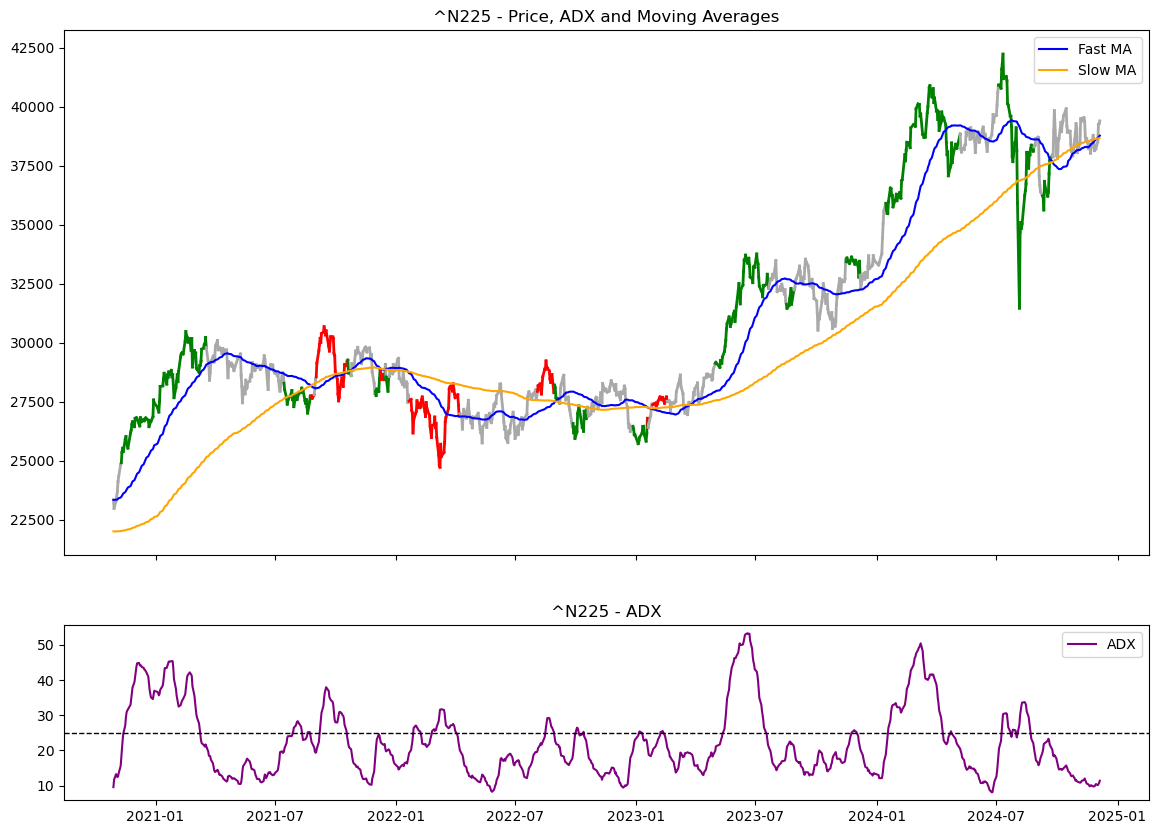

In [13]:
df = data.copy()
# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1], df['Close'].iloc[i-1:i+1], 
             color='green' if df['Signal'].iloc[i] == 1 else 
                   ('red' if df['Signal'].iloc[i] == -1 else 'darkgrey'), linewidth=2)

# Plot the Moving Averages
ax1.plot(df['MA_fast'], label='Fast MA', color='blue')
ax1.plot(df['MA_slow'], label='Slow MA', color='orange')
ax1.set_title(f'{ticker} - Price, ADX and Moving Averages')
ax1.legend(loc='best')

# Plot ADX on the second subplot (smaller height)
ax2.plot(df.index, df['ADX'], label='ADX', color='purple')
ax2.axhline(25, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at ADX=25
ax2.set_title(f'{ticker} - ADX')
ax2.legend(loc='best')

plt.show()

In [15]:
def calculate_returns(df_for_returns, col_for_returns = 'Adj Close', col_for_signal = 'Trend'):

    stats = {}

    # Calculate daily returns
    df_for_returns['Daily_Returns'] = df_for_returns[col_for_returns].pct_change()
    df_for_returns['Returns'] = df_for_returns['Daily_Returns'] * df_for_returns[col_for_signal].shift(1)
    df_for_returns['Returns'] = df_for_returns['Returns'].fillna(0)
    df_for_returns['Equity_Curve'] = 100 * (1 + df_for_returns['Returns']).cumprod()


    return df_for_returns

data = calculate_returns(data, col_for_returns = 'Adj Close', col_for_signal = 'Signal')

In [17]:
def calculate_benchmark_returns(df_for_returns, col_for_returns = 'Adj Close'):

    stats = {}

    # Calculate daily returns
    df_for_returns['Benchmark_Returns'] = df_for_returns[col_for_returns].pct_change()
    df_for_returns['Benchmark_Returns'] = df_for_returns['Benchmark_Returns'].fillna(0)
    df_for_returns['Benchmark_Equity_Curve'] = 100 * (1 + df_for_returns['Benchmark_Returns']).cumprod()

    return df_for_returns

data  = calculate_benchmark_returns(data, col_for_returns = 'Adj Close')

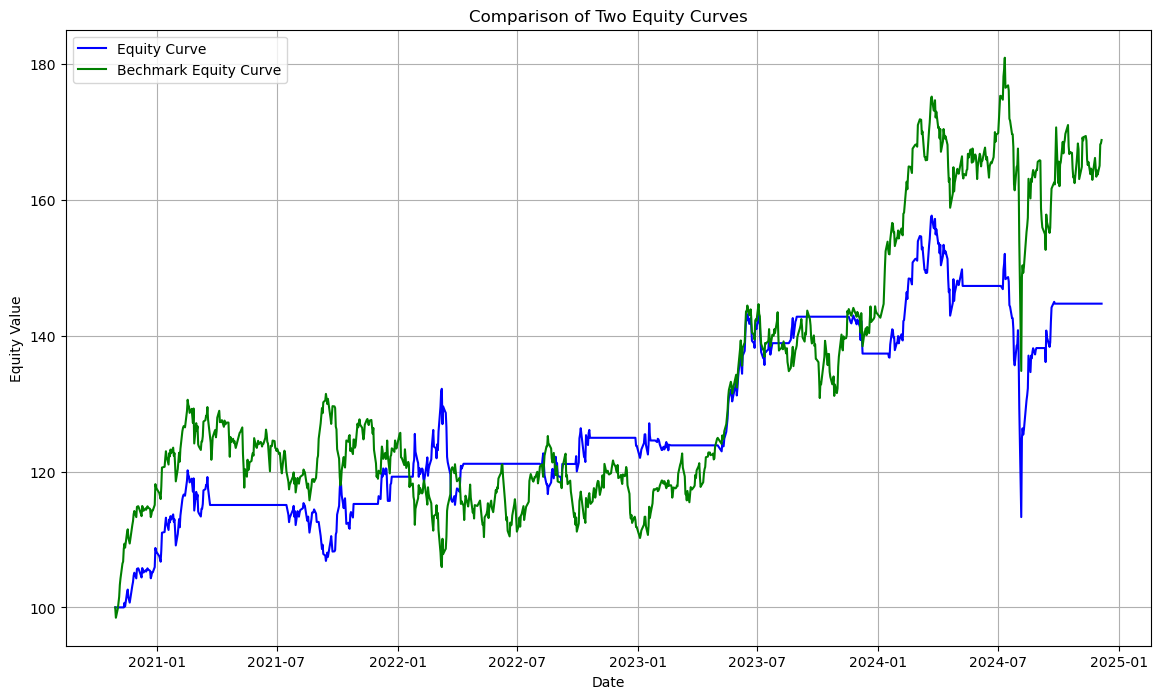

In [19]:
# Set up the figure and axes
plt.figure(figsize=(14, 8))

# Plot both equity curves
plt.plot(data.index, data['Equity_Curve'], label='Equity Curve', color='blue')
plt.plot(data.index, data['Benchmark_Equity_Curve'], label='Bechmark Equity Curve', color='green')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.title('Comparison of Two Equity Curves')
plt.legend()

# Show the plot
plt.grid()
plt.show()

In [21]:
time_in_market = data['Signal'][data['Signal'] != 0].count() / len(data)
print(f"Strategy Time Exposure: {time_in_market * 100:.2f}%")

Strategy Time Exposure: 47.91%


In [23]:
# Set up the annual rates dictionary
# 日本のMRFの利回りに置換え
annual_rates = {
    2020: 0.0001,
    2021: 0.0001,
    2022: 0.0001,
    2023: 0.0005,
    2024: 0.0015
}

# Create a new column that holds the difference in days between the current row and the previous one
data['Days_Difference'] = data.index.to_series().diff().dt.days
data['Days_Difference'] = data['Days_Difference'].fillna(1)

# Extract the year from the index and create a new column for the year
data['Year'] = data.index.year
# Calculate daily rates
daily_rates= {year: (1 + rate) ** (1 / 365) - 1 for year, rate in annual_rates.items()}
# Map the daily rates to the corresponding year and create a new column for the daily rate
data['Daily_Rate_Returns'] = data['Year'].map(daily_rates) * data['Days_Difference']

# Calculate the days that there is an open position
data['Open_Position'] = data['Signal'].shift(1)
# data['Open_Position'] = data['Signal'].shift(1)
data['Open_Position'] = data['Open_Position'].fillna(0)

data['Returns_Combined'] = data.apply(lambda row: row['Open_Position'] * row['Daily_Returns'] if row['Open_Position'] != 0 else row['Daily_Rate_Returns'], axis=1)
data['Returns_Combined'] = data['Returns_Combined'].fillna(0)
data['Equity_Curve_including_interest'] = 100 * (1 + data['Returns_Combined']).cumprod()

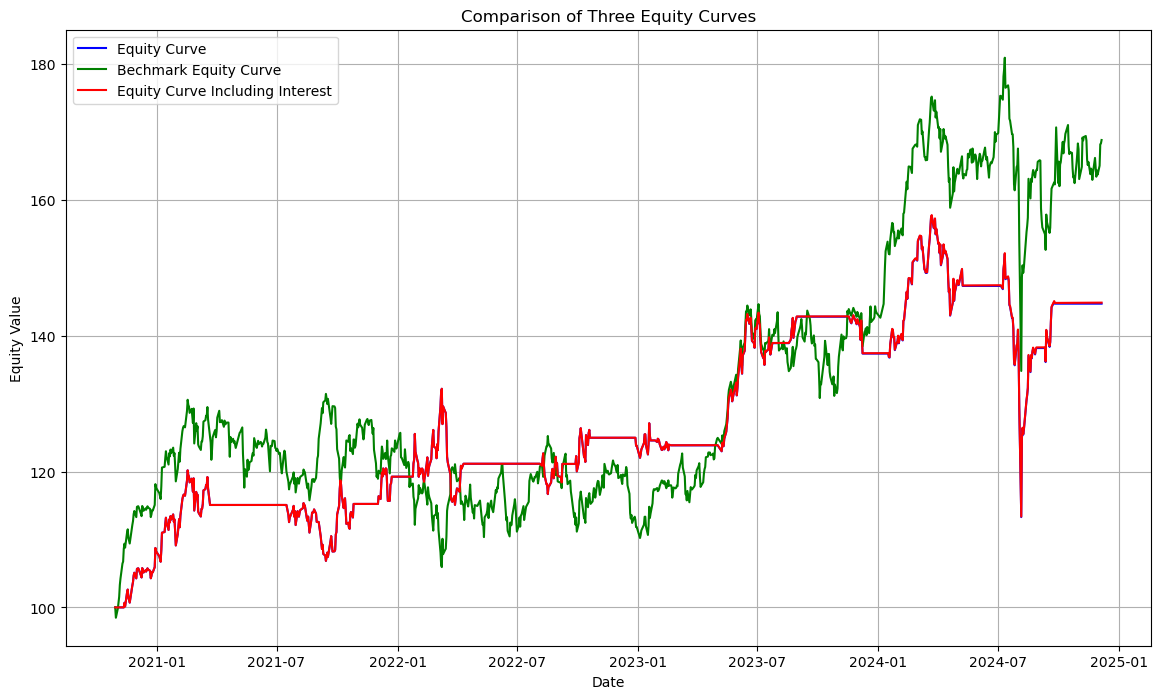

In [25]:
# Set up the figure and axes
plt.figure(figsize=(14, 8))

# Plot both equity curves
plt.plot(data.index, data['Equity_Curve'], label='Equity Curve', color='blue')
plt.plot(data.index, data['Benchmark_Equity_Curve'], label='Bechmark Equity Curve', color='green')
plt.plot(data.index, data['Equity_Curve_including_interest'], label='Equity Curve Including Interest', color='red')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.title('Comparison of Three Equity Curves')
plt.legend()

# Show the plot
plt.grid()
plt.show()

In [33]:
def max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / roll_max - 1.0
    max_drawdown = drawdown.cummin()
    return max_drawdown.min()

max_dd_strategy = max_drawdown(data['Equity_Curve'])
max_dd_market = max_drawdown(data['Benchmark_Equity_Curve'])
max_dd_market_combined = max_drawdown(data['Equity_Curve_including_interest'])

print(f"Strategy Maximum Drawdown: {max_dd_strategy * 100:.2f}%")
print(f"Benchmark Maximum Drawdown: {max_dd_market * 100:.2f}%")
print(f"Strategy Combined Maximum Drawdown: {max_dd_market_combined * 100:.2f}%")

Strategy Maximum Drawdown: -28.16%
Benchmark Maximum Drawdown: -25.50%
Strategy Combined Maximum Drawdown: -28.14%


In [37]:
# Sharpe Ratio
annual_return_strategy = data['Returns'].mean() * 252
annual_volatility_strategy = data['Returns'].std() * np.sqrt(252)
sharpe_ratio_strategy = annual_return_strategy / annual_volatility_strategy

annual_return_market = data['Benchmark_Returns'].mean() * 252
annual_volatility_market = data['Benchmark_Returns'].std() * np.sqrt(252)
sharpe_ratio_market = annual_return_market / annual_volatility_market

annual_return_market_combined = data['Returns_Combined'].mean() * 252
annual_volatility_market_combined = data['Returns_Combined'].std() * np.sqrt(252)
sharpe_ratio_market_combined = annual_return_market_combined / annual_volatility_market_combined

print(f"Strategy Sharpe Ratio: {sharpe_ratio_strategy:.2f}")
print(f"Benchmark Sharpe Ratio: {sharpe_ratio_market:.2f}")
print(f"Strategy Combined Sharpe Ratio: {sharpe_ratio_market_combined:.2f}")

Strategy Sharpe Ratio: 0.66
Benchmark Sharpe Ratio: 0.74
Strategy Combined Sharpe Ratio: 0.67


In [43]:
# Downside Volatility
downside_volatility_strategy = data[data['Returns'] < 0]['Returns'].std() * np.sqrt(252)
sortino_ratio_strategy = annual_return_strategy / downside_volatility_strategy

downside_volatility_market = data[data['Benchmark_Returns'] < 0]['Benchmark_Returns'].std() * np.sqrt(252)
sortino_ratio_market = annual_return_market / downside_volatility_market


downside_volatility_market_combined = data[data['Benchmark_Returns'] < 0]['Benchmark_Returns'].std() * np.sqrt(252)
sortino_ratio_market_combined = annual_return_market_combined / downside_volatility_market_combined

print(f"Strategy Sortino Ratio: {sortino_ratio_strategy:.2f}")
print(f"Benchmark Sortino Ratio: {sortino_ratio_market:.2f}")
print(f"Strategy Combined Sortino Ratio: {sortino_ratio_market_combined:.2f}")

Strategy Sortino Ratio: 0.59
Benchmark Sortino Ratio: 1.00
Strategy Combined Sortino Ratio: 0.69


In [45]:
# Function to calculate volatility (standard deviation of returns)
def volatility(cumulative_returns):
    returns = cumulative_returns.pct_change().dropna()
    return returns.std()

# Assuming `data` is your DataFrame containing multiple equity curves
vol_strategy = volatility(data['Equity_Curve'])
vol_market = volatility(data['Benchmark_Equity_Curve'])
vol_market_combined = volatility(data['Equity_Curve_including_interest'])

print(f"Strategy Volatility: {vol_strategy:.4f}")
print(f"Benchmark Volatility: {vol_market:.4f}")
print(f"Strategy Combined Volatility: {vol_market_combined:.4f}")

Strategy Volatility: 0.0100
Benchmark Volatility: 0.0130
Strategy Combined Volatility: 0.0100
